# 시계열 예측 비교 (랜덤 포레스트)
- 랜덤 포레스트
- 선형 모델
- MLP
- CNN
- RNN

## 예측 타입
- 단변수 예측
- 멀티스텝 예측
- 다중변수 예측
- 다중변수 멀티스텝 예측


In [6]:
!pip install tensorflow

     |████████████████████████████████| 57 kB 680 kB/s eta 0:00:011


In [9]:
import tensorflow

In [10]:
tensorflow.__version__

'1.14.0'

In [5]:
!pip install keras

In [7]:
keras.__version__

'2.3.1'

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline
# from keras.layers import Dense
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GRU, LSTM, SimpleRNN
# from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
# import keras
from sklearn.metrics import r2_score
import warnings
warnings.simplefilter('ignore')
%config InlineBackend.figure_format = 'retina'
# plt.rcParams['figure.dpi'] = 100

Using TensorFlow backend.
/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/hwa-kim/opt/anaconda3/lib/pytho

# 데이터 다운로드

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/bike_train.csv", parse_dates=["datetime"])
df[:3]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


## 자전거 대여수 (시계열 데이터)

In [3]:
count = df["count"].values
print(count.shape)

(10886,)


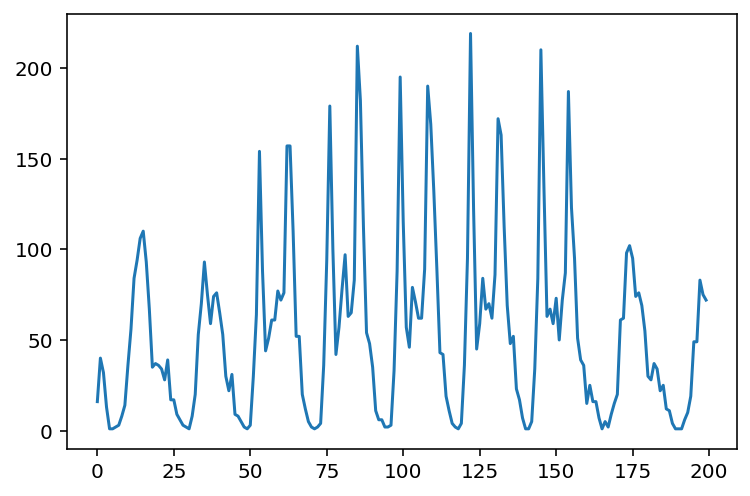

In [4]:
plt.plot(count[:200])

# 머신러닝 방법
- 랜덤 포레스트

## datetime 날짜 데이터 분해

In [15]:
df['datetime'].dt.year

0        2011
1        2011
2        2011
3        2011
4        2011
         ... 
10881    2012
10882    2012
10883    2012
10884    2012
10885    2012
Name: datetime, Length: 10886, dtype: int64

In [16]:
df["d-year"] = df["datetime"].dt.year
df["d-month"] = df["datetime"].dt.month
df["d-day"] = df["datetime"].dt.day
df["d-hour"] = df["datetime"].dt.hour
df["d-dayofweek"] = df["datetime"].dt.dayofweek

df[["datetime", "d-year", "d-month", "d-day", "d-hour","d-dayofweek" ]].head()

,datetime,d-year,d-month,d-day,d-hour,d-dayofweek
0,2011-01-01 00:00:00,2011,1,1,0,5
1,2011-01-01 01:00:00,2011,1,1,1,5
2,2011-01-01 02:00:00,2011,1,1,2,5
3,2011-01-01 03:00:00,2011,1,1,3,5
4,2011-01-01 04:00:00,2011,1,1,4,5


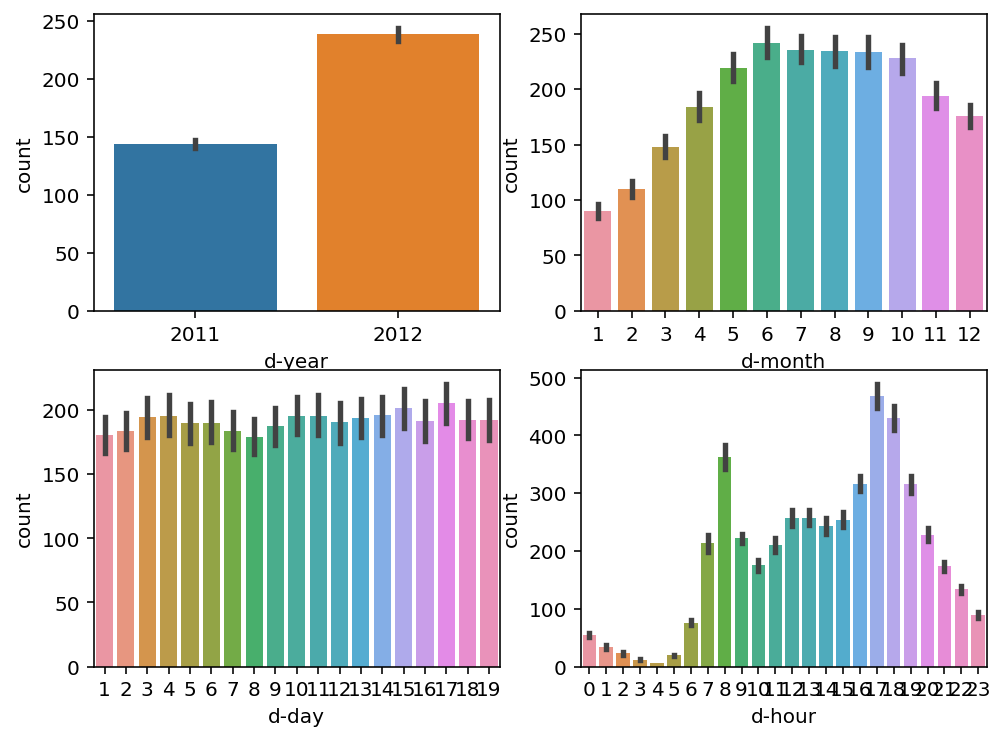

In [17]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,
              figsize=(8,6))
sns.barplot(data=df, x="d-year", y="count", ax=ax1)
sns.barplot(data=df, x="d-month", y="count", ax=ax2)
sns.barplot(data=df, x="d-day", y="count", ax=ax3)
sns.barplot(data=df, x="d-hour", y="count", ax=ax4)

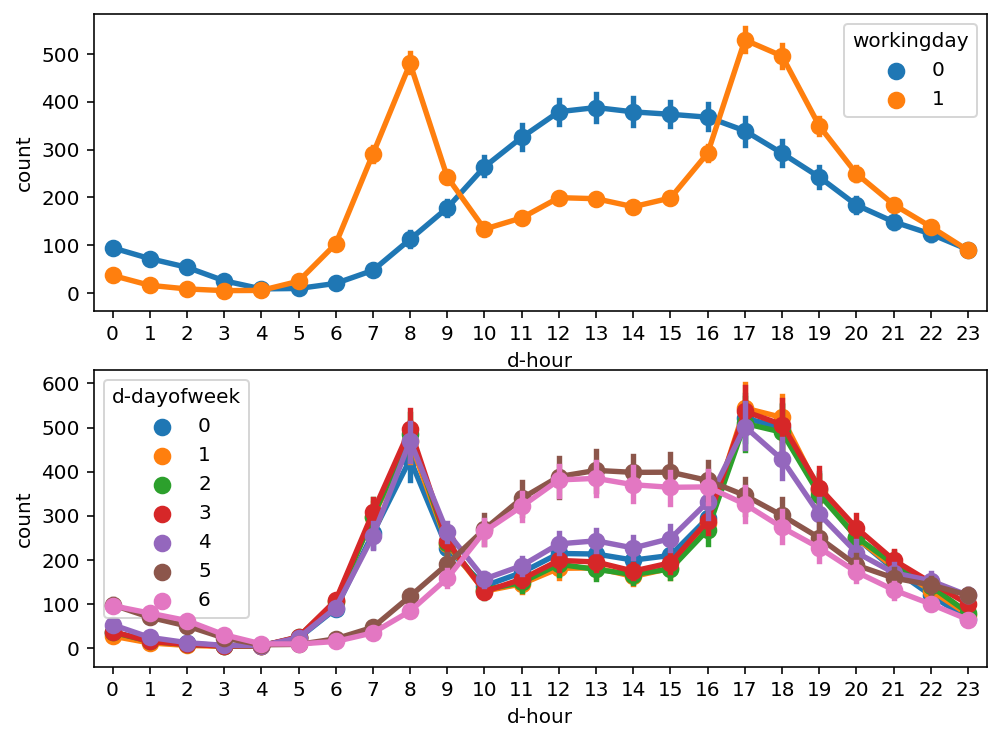

In [18]:
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(8, 6)

sns.pointplot(data=df, x="d-hour", y="count", hue="workingday", ax=ax1)
sns.pointplot(data=df, x="d-hour", y="count", hue="d-dayofweek", ax=ax2)

## 훈련에 사용할 특성 선택

In [9]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'd-year', 'd-month', 'd-day', 'd-hour', 'd-dayofweek'],
      dtype='object')

In [49]:
features = ["season", "holiday", "workingday", "weather", "temp", "atemp", 
            "humidity", "windspeed", "d-year", "d-hour", "d-dayofweek"]

features = ["season", "holiday", "workingday", "temp","d-hour", "d-dayofweek"]
# features = ["workingday", "d-hour"]

## 랜덤 포레스트
### 데이터 셔플링 (train_test_split)

In [50]:
X = df[features].values
y = count
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [51]:
model = RandomForestRegressor(n_estimators= 100)
model.fit(X_train, y_train)
model.score(X_test, y_test) # R2

0.7695846337147588

- 성능이 매우 좋다

### 주요 특성 변수

In [52]:
def feature_importances_fig(features, importances):
    df = pd.DataFrame({'feature':features,'importance':importances})
    df = df.sort_values('importance', ascending=False)
    ypos = np.arange(len(df.feature))

    plt.figure(figsize=(6,4))
    plt.barh(df.feature, df.importance)
    plt.yticks(ypos, df.feature)
    plt.xlabel('Importance')
    plt.ylabel('Variable')
    plt.xlim(0, 1)
    plt.ylim(-1, len(df.feature))
    plt.show()

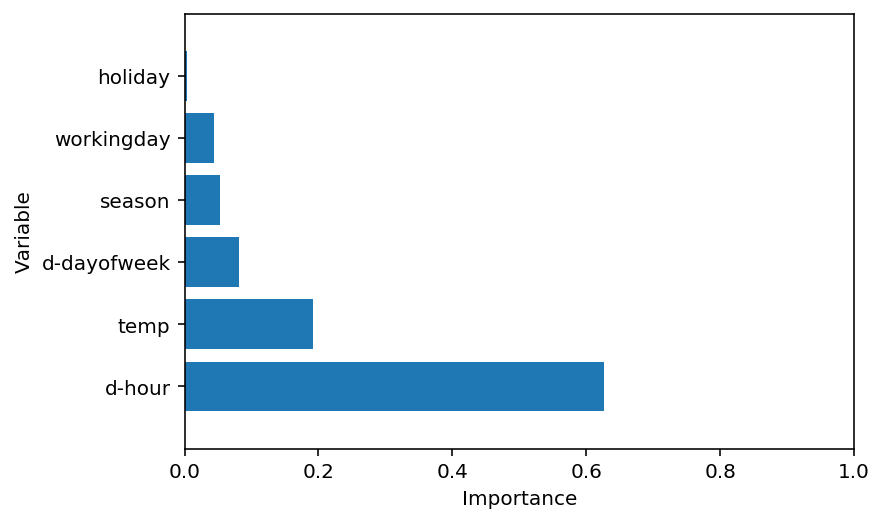

In [53]:
feature_importances_fig(features, model.feature_importances_)

### 시각화 함수

In [54]:
# 실제값과 예측치 비교
def plot_y_pred(y_test, y_pred):
    plt.figure(figsize=(8, 5))
    plt.plot(y_test, c='r')
    plt.plot(y_pred, c='b')
    plt.show()
    print("R2=", r2_score(y_test, y_pred).round(3))
    error = abs(y_test - y_pred)
    print("MAE=", error.mean().round(3))
    print("rmse=", np.sqrt((error**2).mean()).round(3))
    print("max=", max(error).round(3))

In [55]:
def scatter_errors(y_test, y_pred):
    error = abs(y_test - y_pred)
    plt.scatter(y_test, error, s=2)

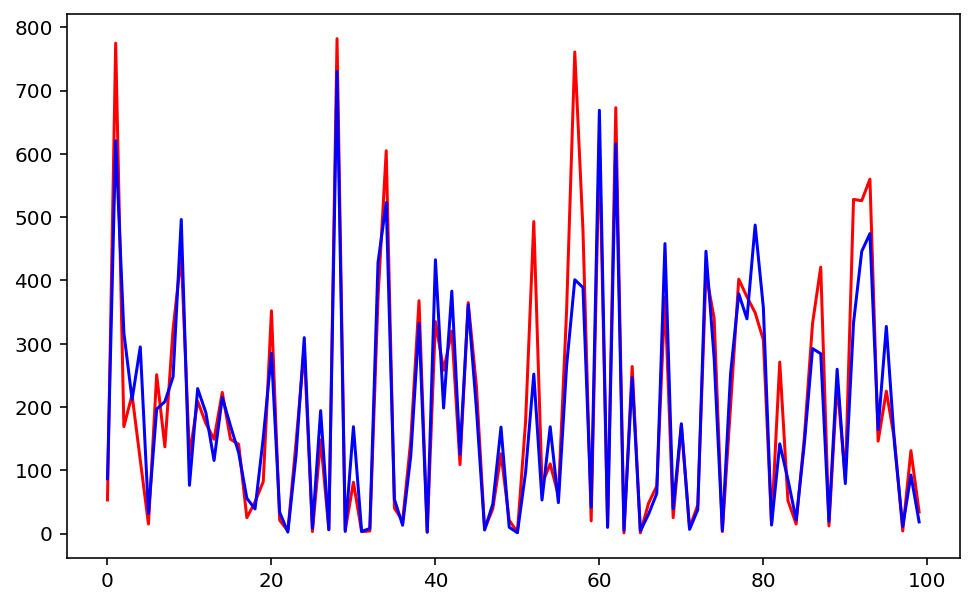

R2= 0.865
MAE= 45.334
rmse= 72.131
max= 359.917


In [56]:
y_pred = model.predict(X_test)
plot_y_pred(y_test[:100], y_pred[:100])

In [18]:
np.vstack((y_test[:10], y_pred[:10].round(0))).T

array([[ 93.,  40.],
       [ 21.,  32.],
       [745., 663.],
       [ 30.,  44.],
       [123., 125.],
       [207., 259.],
       [333., 265.],
       [106., 123.],
       [ 32.,  45.],
       [170., 196.]])

# 선형 모델

In [19]:
cut = np.int((len(count)*0.7))
train = count[:cut]
test = count[cut:]
train.shape, test.shape

((7620,), (3266,))

## 머신 러닝 모델에서 사용할 X, y 구조 생성

In [20]:
def split_seq_2(sequence, n_steps_in, n_steps_out):
  x, y = [],[]
  for i in range(len(sequence)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    if out_end_ix > len(sequence):
        break
    seq_x, seq_y = sequence[i:end_ix], sequence[out_end_ix-1]
    x.append(seq_x)
    y.append(seq_y)
  return np.array(x), np.array(y)

## 적절한 n_steps_in 찾기

In [21]:
lr= LinearRegression()
for n_steps in range(1,24*20,24):
  x_train, y_train = split_seq_2(train, n_steps, 1)
  x_test, y_test = split_seq_2(test, n_steps, 1)
  lr.fit(x_train, y_train) 
  print(n_steps, lr.score(x_test, y_test).round(3))

1 0.662
25 0.866
49 0.877
73 0.883
97 0.886
121 0.89
145 0.897
169 0.902
193 0.901
217 0.902
241 0.902
265 0.901
289 0.901
313 0.901
337 0.901
361 0.901
385 0.902
409 0.902
433 0.901
457 0.901


### 최적값 선택

240 0.902


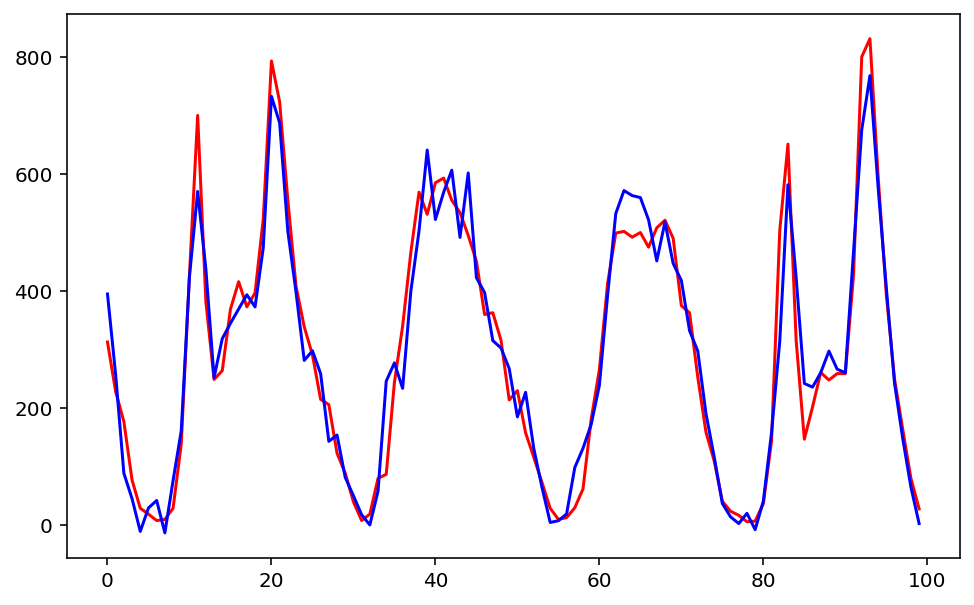

In [22]:
n_steps = 10*24
x_train, y_train = split_seq_2(train, n_steps, 1)
x_test, y_test = split_seq_2(test, n_steps, 1)
lr.fit(x_train, y_train) 
print(n_steps, lr.score(x_test, y_test).round(3))
y_pred = lr.predict(x_test)
plot_y_pred(y_test[:100], y_pred[:100])

- 1시간 후를 예측했으므로 정확하다

MAE= 47.253
rmse= 67.918
max= 453.003


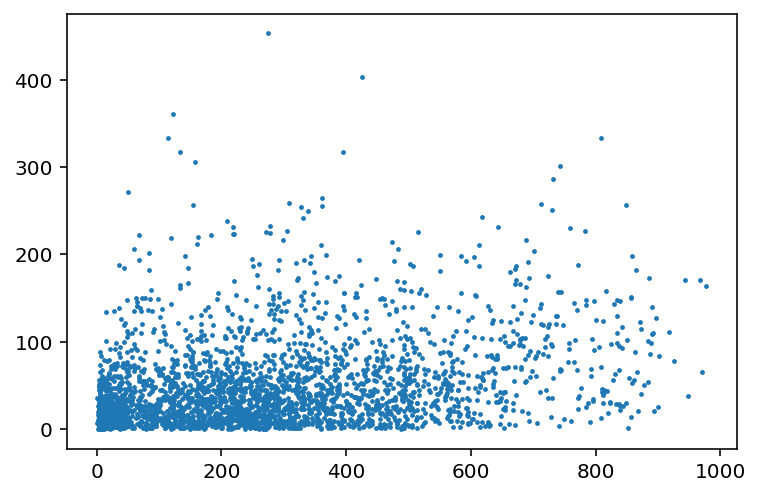

In [23]:
scatter_errors(y_test, y_pred)

## 미래 예측

In [57]:
lr = LinearRegression()
n_steps_in = 10*24
n_futures = [1,24, 24*7, 24*7*2, 24*7*3, 24*7*10]
for n_steps_out in n_futures:
  x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
  x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)
  lr.fit(x_train, y_train) 
  print(n_steps_out, ':', lr.score(x_test, y_test).round(3))

NameError: name 'split_seq_2' is not defined

## 최적값 선택 in, out

In [25]:
n_steps_in = 24*10
n_steps_out= 24*7
x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)
lr.fit(x_train, y_train) 
print(n_steps_out, ',', lr.score(x_test, y_test).round(3))

168 , 0.727


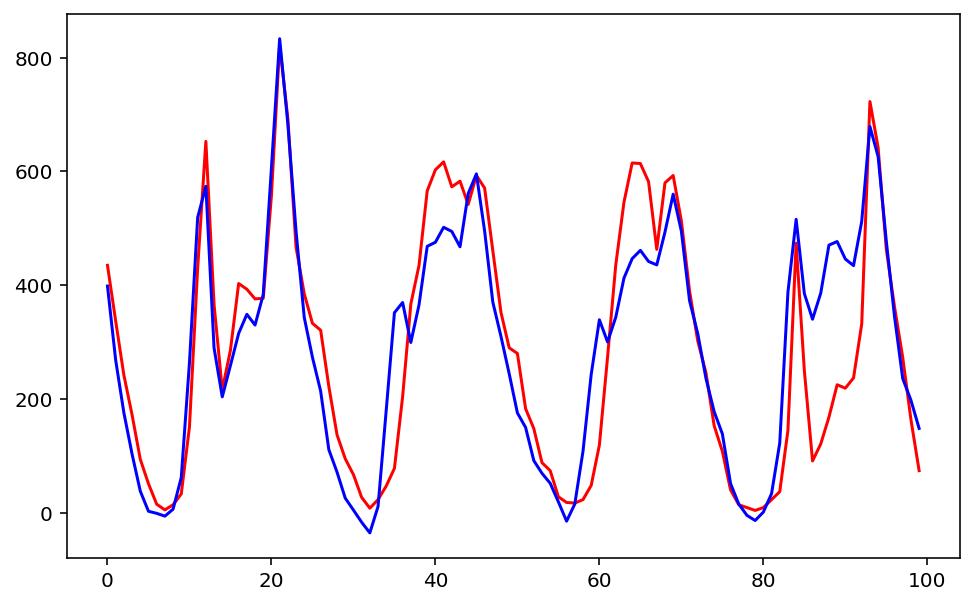

In [26]:
y_pred = lr.predict(x_test)
plot_y_pred(y_test[:100], y_pred[:100])

MAE= 80.656
rmse= 113.005
max= 565.626


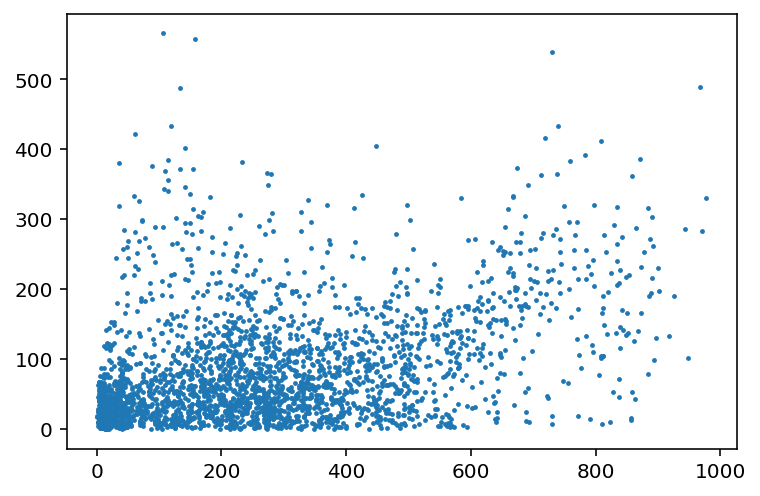

In [27]:
scatter_errors(y_test, y_pred)

# 신경망 사용
- 시간이 오래 걸리므로 colab에서 실행 권장

In [28]:
n_steps_in = 24*10
n_steps_out= 24*7
x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)

## MLP

In [29]:
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=n_steps_in)) 
model.add(Dense(200, activation='relu'))
model.add(Dense(1))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               48200     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 88,601
Trainable params: 88,601
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(x_train, y_train, batch_size=20, epochs=100,
                validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/30
289/289 [==============================] - 1s 3ms/step - loss: 8782.6338 - val_loss: 18984.3164
Epoch 2/30
289/289 [==============================] - 1s 2ms/step - loss: 7279.6748 - val_loss: 13908.0303
Epoch 3/30
289/289 [==============================] - 1s 2ms/step - loss: 6762.8140 - val_loss: 14652.3369
Epoch 4/30
289/289 [==============================] - 1s 2ms/step - loss: 6491.5249 - val_loss: 22374.6777
Epoch 5/30
289/289 [==============================] - 1s 2ms/step - loss: 6368.3682 - val_loss: 15133.8008
Epoch 6/30
289/289 [==============================] - 1s 2ms/step - loss: 6023.4141 - val_loss: 15985.3906
Epoch 7/30
289/289 [==============================] - 1s 2ms/step - loss: 5801.9302 - val_loss: 13311.2266
Epoch 8/30
289/289 [==============================] - 1s 2ms/step - loss: 5690.1011 - val_loss: 14665.9580
Epoch 9/30
289/289 [==============================] - 1s 2ms/step - loss: 5614.4810 - val_loss: 14671.5371
Epoch 10/30
289/289 [================

In [32]:
y_pred = model.predict(x_test)
r2_score(y_test, y_pred)

0.6428529736082456

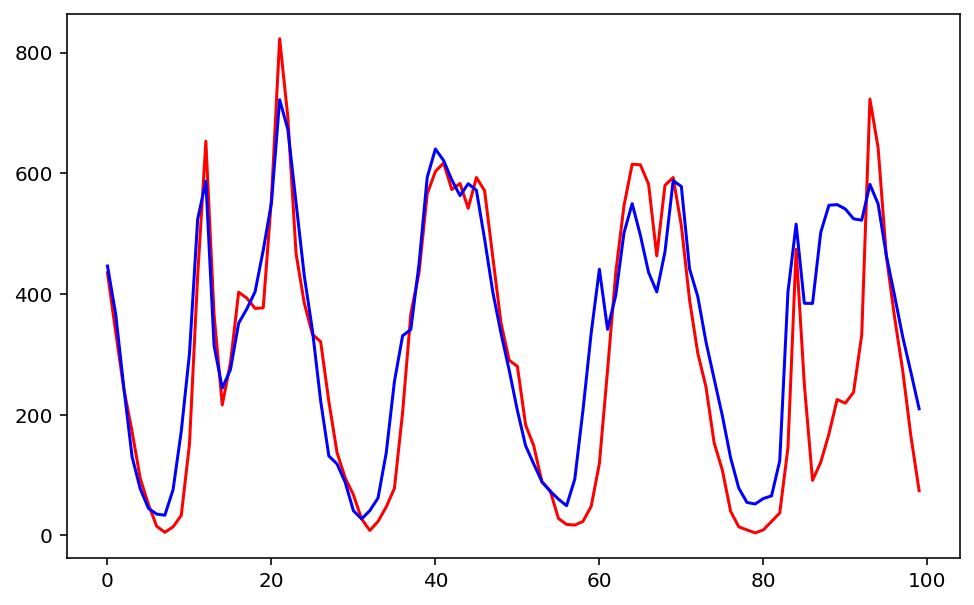

In [33]:
plot_y_pred(y_test[:100], y_pred[:100])

In [34]:
y_pred

array([[446.29572],
       [366.78244],
       [244.10294],
       ...,
       [209.0355 ],
       [165.93298],
       [ 95.12703]], dtype=float32)

In [35]:
y_pred.shape

(2859, 1)

MAE= 97.243
rmse= 129.293
max= 517.29


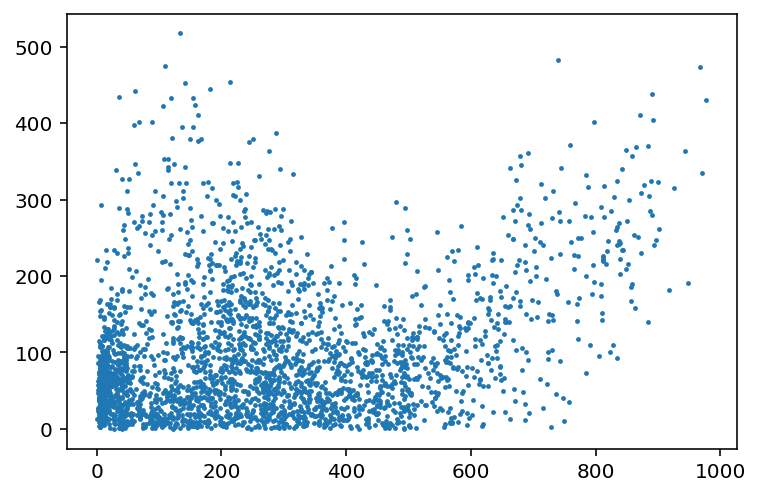

In [36]:
scatter_errors(y_test, y_pred.ravel())

## CNN

In [37]:
model = Sequential()
model.add(Reshape((n_steps_in,1), input_shape=(n_steps_in,)))
model.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps_in,1))) 
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 2))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 240, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 239, 64)           192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 119, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 118, 64)           8256      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 59, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 58, 128)           16512     
_________________________________________________________________
flatten (Flatten)            (None, 7424)             

In [39]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(x_train, y_train, batch_size=20, epochs=100,
        validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/100
289/289 [==============================] - 1s 4ms/step - loss: 320.7032 - val_loss: 18343.1660
Epoch 2/100
289/289 [==============================] - 1s 3ms/step - loss: 370.6333 - val_loss: 17385.3535
Epoch 3/100
289/289 [==============================] - 1s 3ms/step - loss: 307.0805 - val_loss: 18397.8828
Epoch 4/100
289/289 [==============================] - 1s 3ms/step - loss: 311.7928 - val_loss: 18020.3242
Epoch 5/100
289/289 [==============================] - 1s 3ms/step - loss: 332.9421 - val_loss: 17900.9551
Epoch 6/100
289/289 [==============================] - 1s 3ms/step - loss: 306.4274 - val_loss: 17566.6445
Epoch 7/100
289/289 [==============================] - 1s 3ms/step - loss: 365.1190 - val_loss: 18253.8066


In [40]:
y_pred = model.predict(x_test)
r2_score(y_test, y_pred)

0.6116816553839477

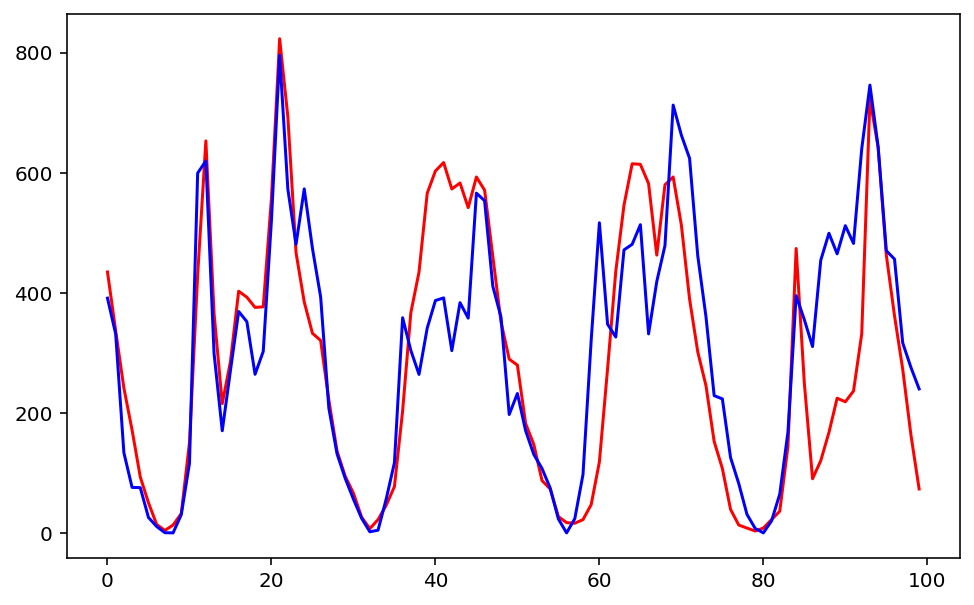

In [41]:
plot_y_pred(y_test[:100], y_pred[:100])

MAE= 91.903
rmse= 134.818
max= 684.603


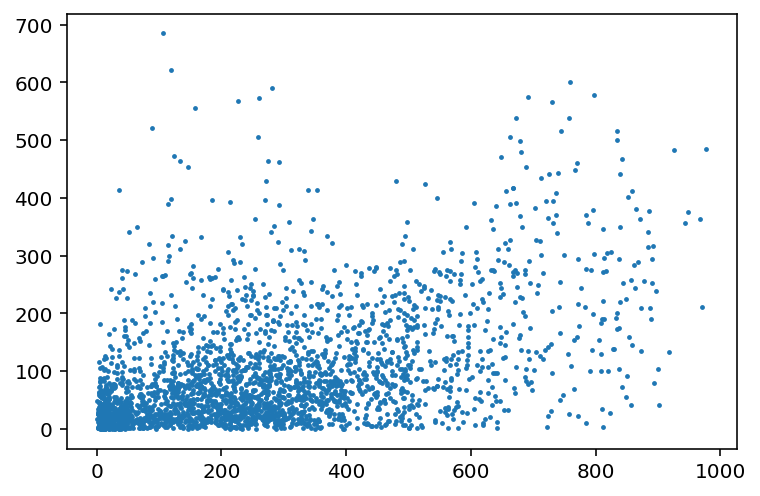

In [42]:
scatter_errors(y_test, y_pred[:,0])

## RNN

In [43]:
model = Sequential()
model.add(Reshape((n_steps_in,1), input_shape=(n_steps_in,)))
model.add(GRU(64, activation='elu', input_shape=(n_steps_in, 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(32, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 240, 1)            0         
_________________________________________________________________
gru (GRU)                    (None, 240, 64)           12864     
_________________________________________________________________
dropout (Dropout)            (None, 240, 64)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 22,305
Trainable params: 22,305
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(x_train, y_train, batch_size=20, epochs=200,
        validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/200
 70/289 [======>.......................] - ETA: 2:55 - loss: 22722.7988

KeyboardInterrupt: ignored

In [ ]:
y_pred = model.predict(test_x)
r2_score(test_y, y_pred)

0.881981964159749

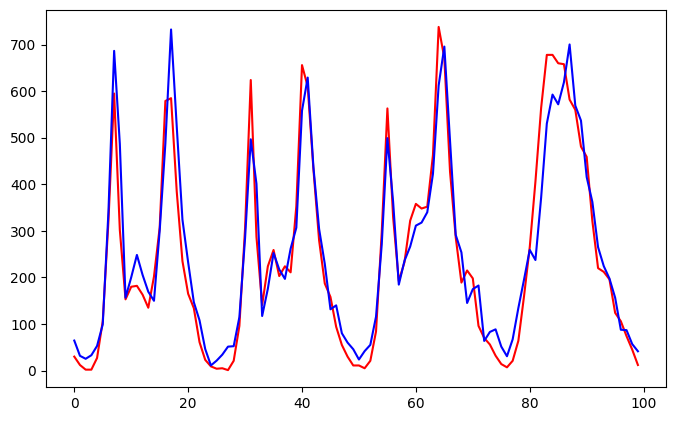

In [ ]:
plot_y_pred(test_y[:100], y_pred[:100])

average= 51.953741291608296
max= 526.6481018066406


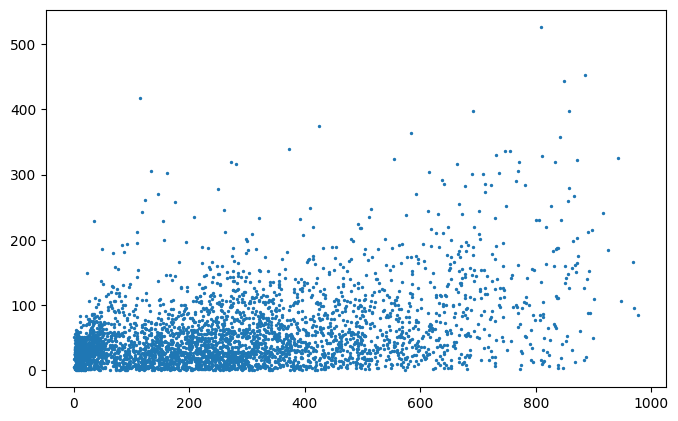

In [ ]:
scatter_errors(test_y, y_pred[:,0])

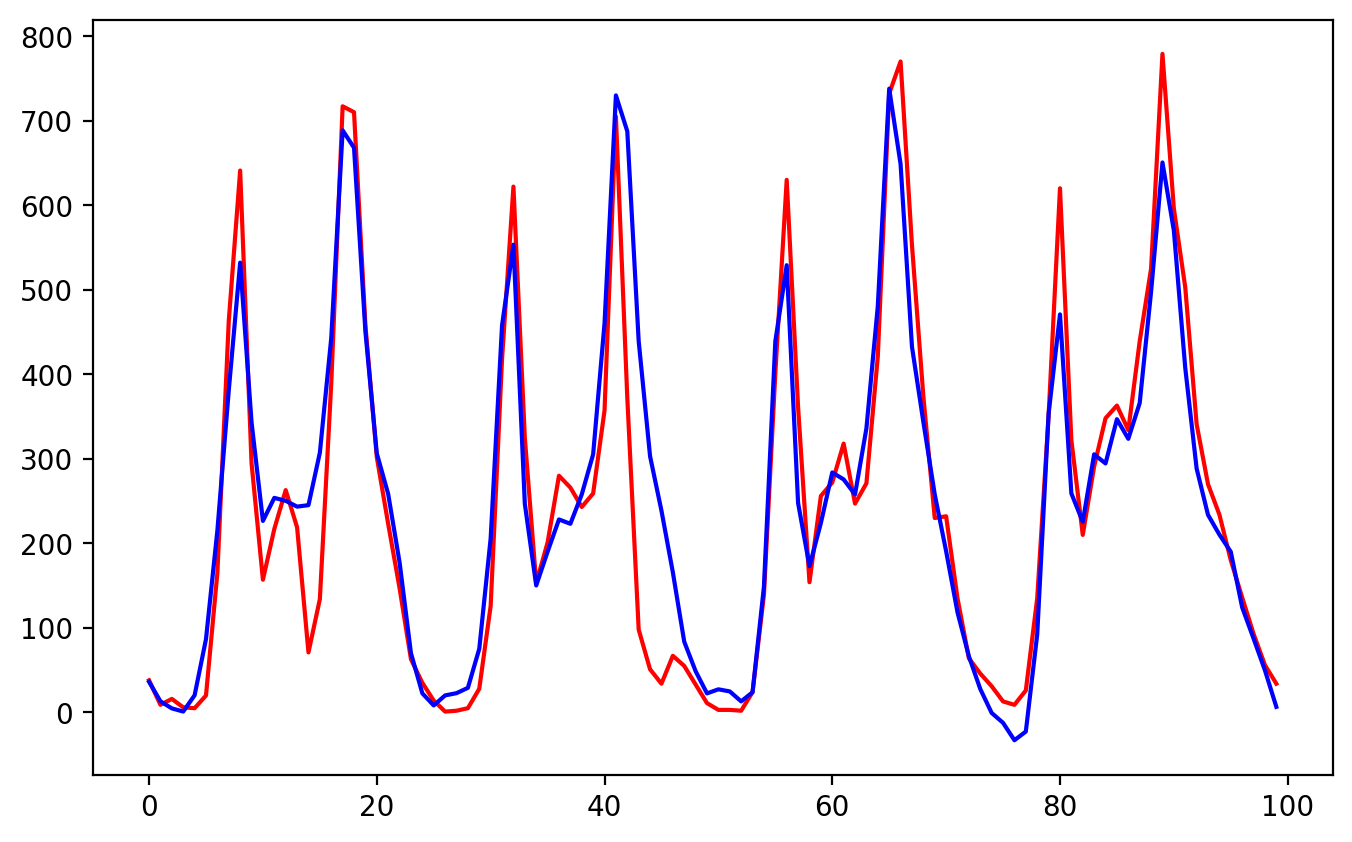

In [ ]:
y_pred = model.predict(x_test)
plot_y_pred(y_test[:100], y_pred[:100])

average= 82.17696896852357
max= 553.068294497697


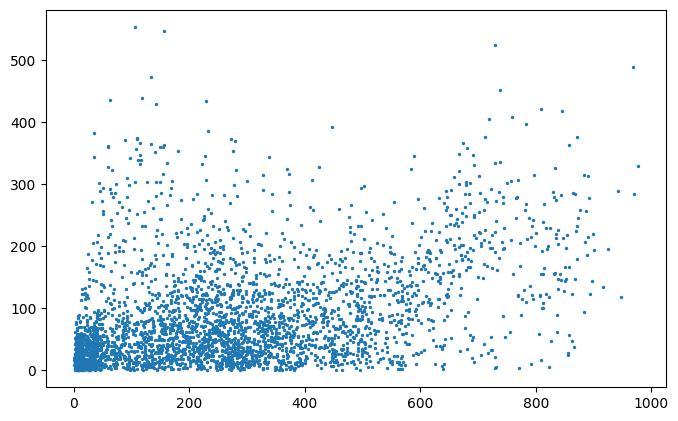

In [ ]:
scatter_errors(y_test, y_pred)

# 다중변수 예측 - 참고

In [45]:
features = ["count", "temp", "humidity","season", "workingday",  "d-year", "d-hour"]
continuous_features = ["count", "temp", "humidity"]
discrete_features = ["season", "workingday", "d-year", "d-hour"]
X2 = df[features]

In [46]:
X2.nunique()

count         822
temp           49
humidity       89
season          4
workingday      2
d-year          2
d-hour         24
dtype: int64

In [47]:
X = pd.get_dummies(X2, columns = discrete_features)
X[:3].T

,0,1,2
count,16.00,40.00,32.00
temp,9.84,9.02,9.02
humidity,81.00,80.00,80.00
season_1,1.00,1.00,1.00
season_2,0.00,0.00,0.00
season_3,0.00,0.00,0.00
season_4,0.00,0.00,0.00
workingday_0,1.00,1.00,1.00
workingday_1,0.00,0.00,0.00
d-year_2011,1.00,1.00,1.00


In [48]:
sc = StandardScaler()
X[continuous_features] = sc.fit_transform(X[continuous_features])
X[:3].T

,0,1,2
count,-0.969294,-0.836797,-0.880962
temp,-1.333661,-1.438907,-1.438907
humidity,0.993213,0.941249,0.941249
season_1,1.000000,1.000000,1.000000
season_2,0.000000,0.000000,0.000000
season_3,0.000000,0.000000,0.000000
season_4,0.000000,0.000000,0.000000
workingday_0,1.000000,1.000000,1.000000
workingday_1,0.000000,0.000000,0.000000
d-year_2011,1.000000,1.000000,1.000000


In [49]:
# 표준 스케일링 변수 (표준편차와 평균)
sc.scale_, sc.mean_

(array([181.13613357,   7.79123196,  19.24414932]),
 array([191.57413191,  20.23085982,  61.88645967]))

In [50]:
count_sigma = sc.scale_[0]
count_mean = sc.mean_[0]
count_sigma, count_mean

(181.1361335742659, 191.57413191254824)

In [52]:
len(X)

10886

In [53]:
cut = np.int((len(X)*0.7))
train = X[:cut].values
test = X[cut:].values
train.shape, test.shape

((7620, 35), (3266, 35))

In [54]:
n_steps_in = 24*10
n_steps_out = 24 * 7
x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)

In [55]:
x_train.shape, y_train.shape

((7213, 240, 35), (7213, 35))

### 최종 예측치는 count만 해당됨

In [57]:
y_train = y_train[:,0]
y_test = y_test[:,0]

In [58]:
x_train.shape, y_train.shape

((7213, 240, 35), (7213,))

In [59]:
n_features = x_train.shape[-1]
n_features

35

## MLP (다중변수 멀티스텝)

In [60]:
model = Sequential()
model.add(Reshape((n_steps_in*n_features,), input_shape=(n_steps_in, n_features))) 
model.add(Dense(300, activation='relu', input_shape=(n_steps_in*n_features,))) 
model.add(Dense(300, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(1))


In [61]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(x_train,y_train, batch_size=20, epochs=200,
                                          validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/200
289/289 [==============================] - 1s 3ms/step - loss: 0.3029 - val_loss: 0.5325
Epoch 2/200
289/289 [==============================] - 1s 3ms/step - loss: 0.2054 - val_loss: 0.5994
Epoch 3/200
289/289 [==============================] - 1s 3ms/step - loss: 0.1741 - val_loss: 0.7163
Epoch 4/200
289/289 [==============================] - 1s 3ms/step - loss: 0.1506 - val_loss: 0.7828
Epoch 5/200
289/289 [==============================] - 1s 3ms/step - loss: 0.1349 - val_loss: 0.7260
Epoch 6/200
289/289 [==============================] - 1s 3ms/step - loss: 0.1182 - val_loss: 0.6781


0.604161492598539


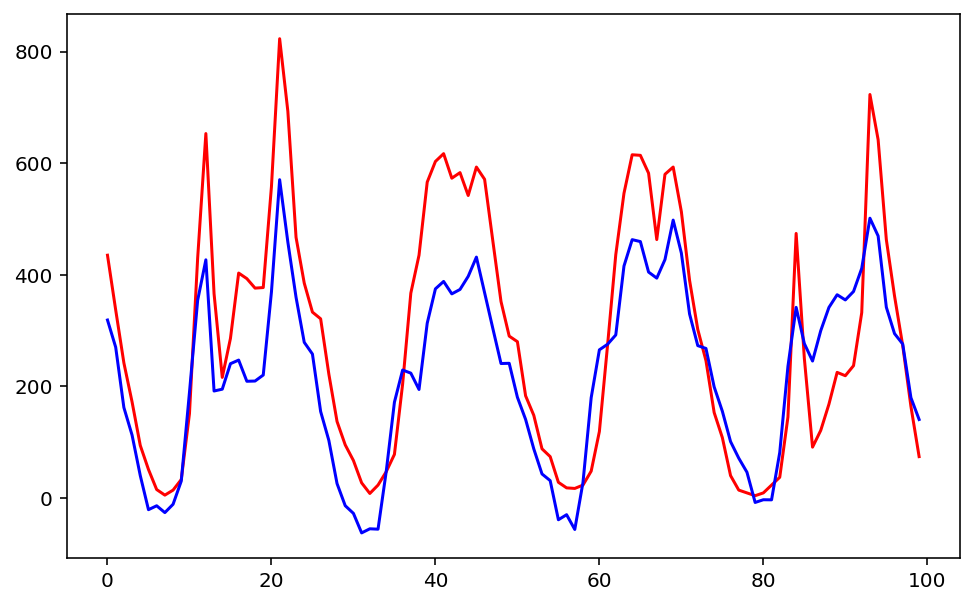

In [62]:
y_pred = model.predict(x_test)
print(r2_score(y_test, y_pred))
plot_y_pred(y_test[:100]*count_sigma+count_mean, y_pred[:100]*count_sigma+count_mean)

In [63]:
count_mean

191.57413191254824

MAE= 99.556
rmse= 136.117
max= 475.339


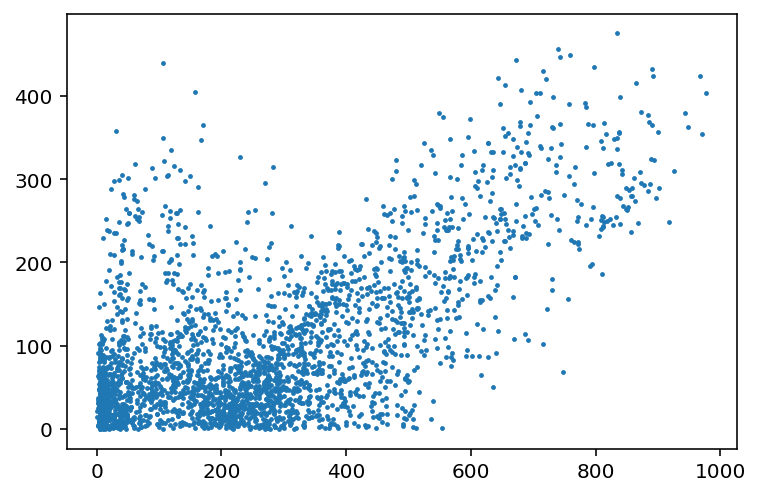

In [64]:
scatter_errors(y_test*count_sigma+count_mean, y_pred[:,0]*count_sigma+count_mean)

## CNN (다중변수 멀티스텝)

In [65]:
model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps_in, n_features))) 
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 2))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 2))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 2))
model.add(MaxPooling1D(2))
model.add(Conv1D(256, 2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 239, 64)           4544      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 119, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 118, 64)           8256      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 59, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 58, 128)           16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 58, 128)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 29, 128)          

In [66]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(x_train, y_train, batch_size=20, epochs=200,
        validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/200
289/289 [==============================] - 1s 5ms/step - loss: 0.3140 - val_loss: 0.5856
Epoch 2/200
289/289 [==============================] - 1s 4ms/step - loss: 0.2356 - val_loss: 0.6554
Epoch 3/200
289/289 [==============================] - 1s 4ms/step - loss: 0.2154 - val_loss: 0.6488
Epoch 4/200
289/289 [==============================] - 1s 5ms/step - loss: 0.1979 - val_loss: 0.6401
Epoch 5/200
289/289 [==============================] - 1s 4ms/step - loss: 0.1845 - val_loss: 0.6138
Epoch 6/200
289/289 [==============================] - 1s 4ms/step - loss: 0.1783 - val_loss: 0.5780
Epoch 7/200
289/289 [==============================] - 1s 4ms/step - loss: 0.1696 - val_loss: 0.6056
Epoch 8/200
289/289 [==============================] - 1s 4ms/step - loss: 0.1639 - val_loss: 0.6387
Epoch 9/200
289/289 [==============================] - 1s 4ms/step - loss: 0.1527 - val_loss: 0.6513
Epoch 10/200
289/289 [==============================] - 1s 4ms/step - loss: 0.1418 - val_lo

0.5464682691350005


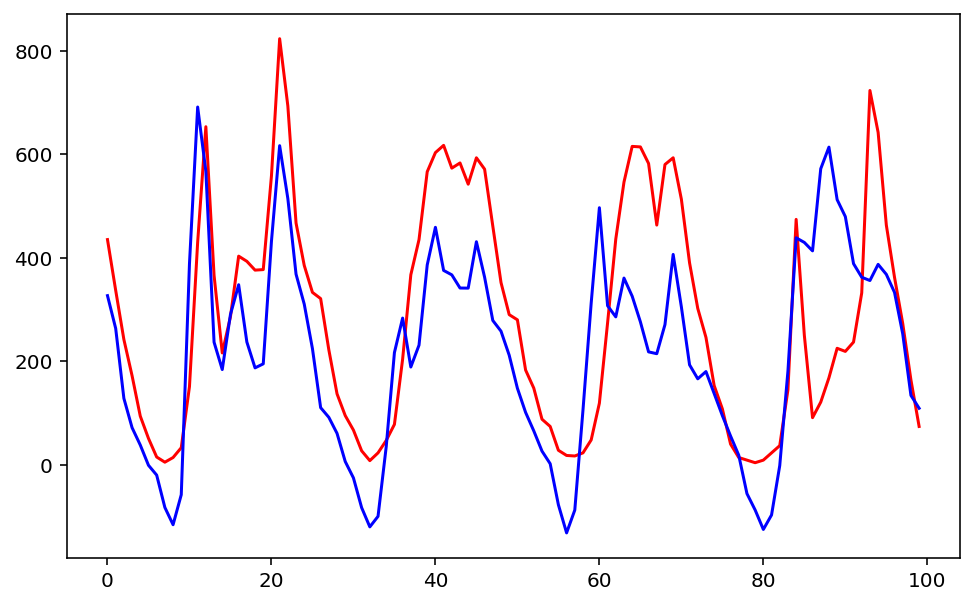

In [67]:
y_pred = model.predict(x_test)
print(r2_score(y_test, y_pred))
plot_y_pred(y_test[:100]*count_sigma+count_mean, y_pred[:100]*count_sigma+count_mean)

MAE= 114.12
rmse= 145.699
max= 573.846


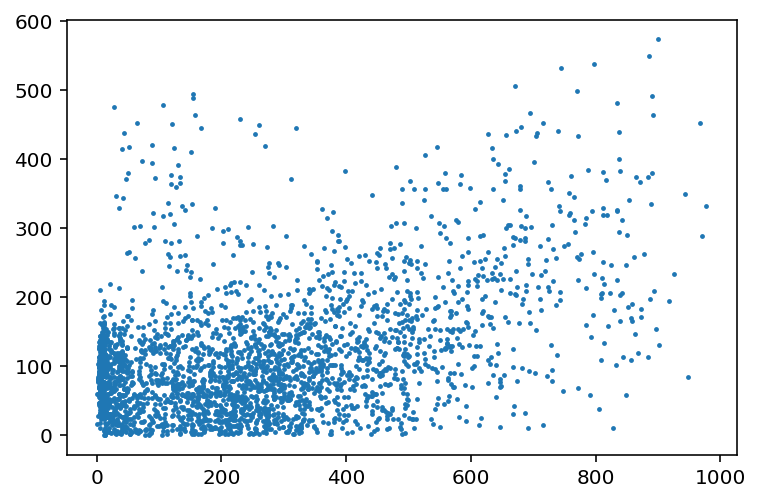

In [68]:
scatter_errors(y_test*count_sigma+count_mean, y_pred[:,0]*count_sigma+count_mean)